In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

In [ ]:
# Load data
data = pd.read_csv('daily_data.csv')

In [ ]:
data.dtypes

day_id                       object
city_id                      object
temperature_celsius         float64
condition_text               object
wind_kph                    float64
wind_degree                   int64
pressure_mb                 float64
precip_mm                   float64
humidity                      int64
cloud                         int64
feels_like_celsius          float64
visibility_km               float64
uv_index                    float64
gust_kph                    float64
air_quality_us-epa-index      int64
sunrise                      object
sunset                       object
dtype: object

In [ ]:
# Display the first few rows of the dataset
data.head()

,day_id,city_id,temperature_celsius,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
0,D0001,C001,27.0,NaN,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,06:04 AM,07:19 PM
1,D0002,C001,22.0,NaN,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,06:05 AM,07:18 PM
2,D0003,C001,20.0,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM
3,D0004,C001,17.0,Clear and Sunny,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM
4,D0005,C001,18.0,NaN,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,06:07 AM,07:15 PM


In [ ]:
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 day_id                         0
city_id                        0
temperature_celsius            0
condition_text              2414
wind_kph                       0
wind_degree                    0
pressure_mb                    0
precip_mm                      0
humidity                       0
cloud                          0
feels_like_celsius             0
visibility_km                  0
uv_index                       0
gust_kph                       0
air_quality_us-epa-index       0
sunrise                        0
sunset                         0
dtype: int64


In [ ]:
data.describe()

,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index
count,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000
mean,22.024577,10.304805,158.994469,1013.745938,0.165299,74.773591,32.073280,23.725752,9.745524,2.216730,16.930522,1.599032
std,6.615540,7.264472,103.021634,6.172045,0.937061,19.335724,32.584184,8.877424,2.489918,2.238163,10.541449,1.062513
min,-2.000000,3.600000,1.000000,982.000000,0.000000,4.000000,0.000000,-4.300000,0.000000,1.000000,0.700000,1.000000
25%,17.000000,5.000000,70.000000,1010.000000,0.000000,66.000000,0.000000,17.000000,10.000000,1.000000,9.000000,1.000000
50%,22.000000,8.300000,150.000000,1014.000000,0.000000,78.000000,25.000000,24.500000,10.000000,1.000000,15.100000,1.000000
75%,27.000000,13.000000,236.000000,1018.000000,0.000000,89.000000,68.000000,30.000000,10.000000,1.000000,22.300000,2.000000
max,45.000000,74.200000,360.000000,1036.000000,28.700000,100.000000,100.000000,73.600000,32.000000,10.000000,75.600000,6.000000


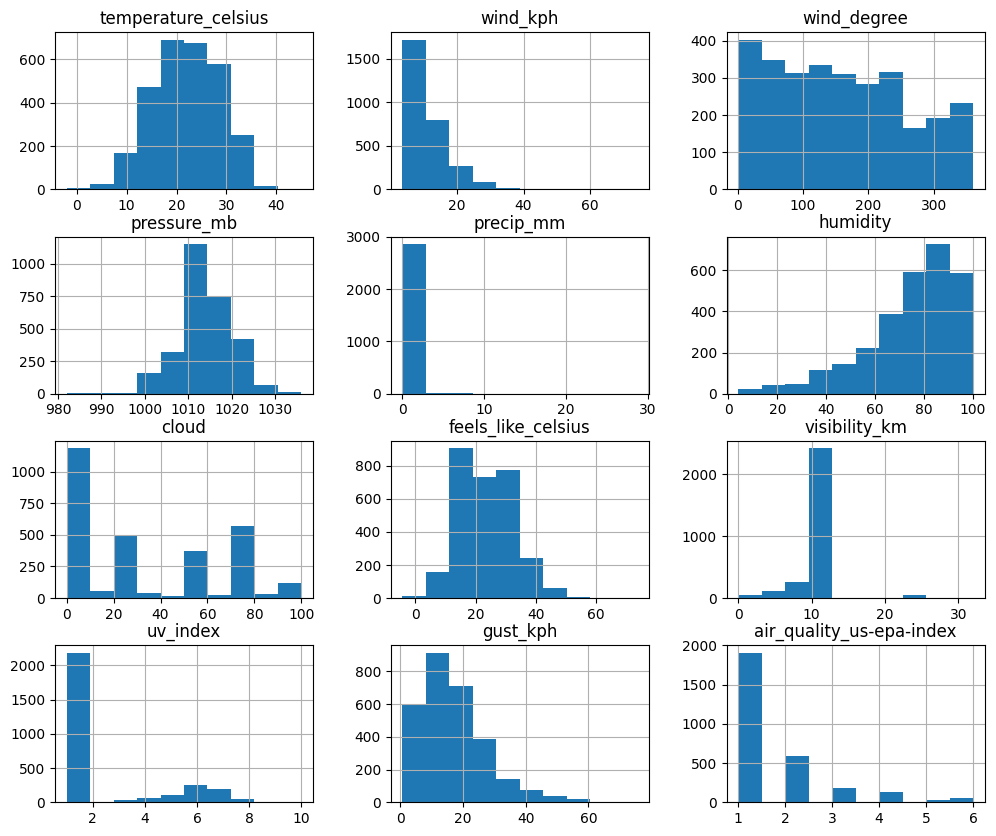

In [ ]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
data[num_features].hist(figsize=(12, 10))
plt.show()

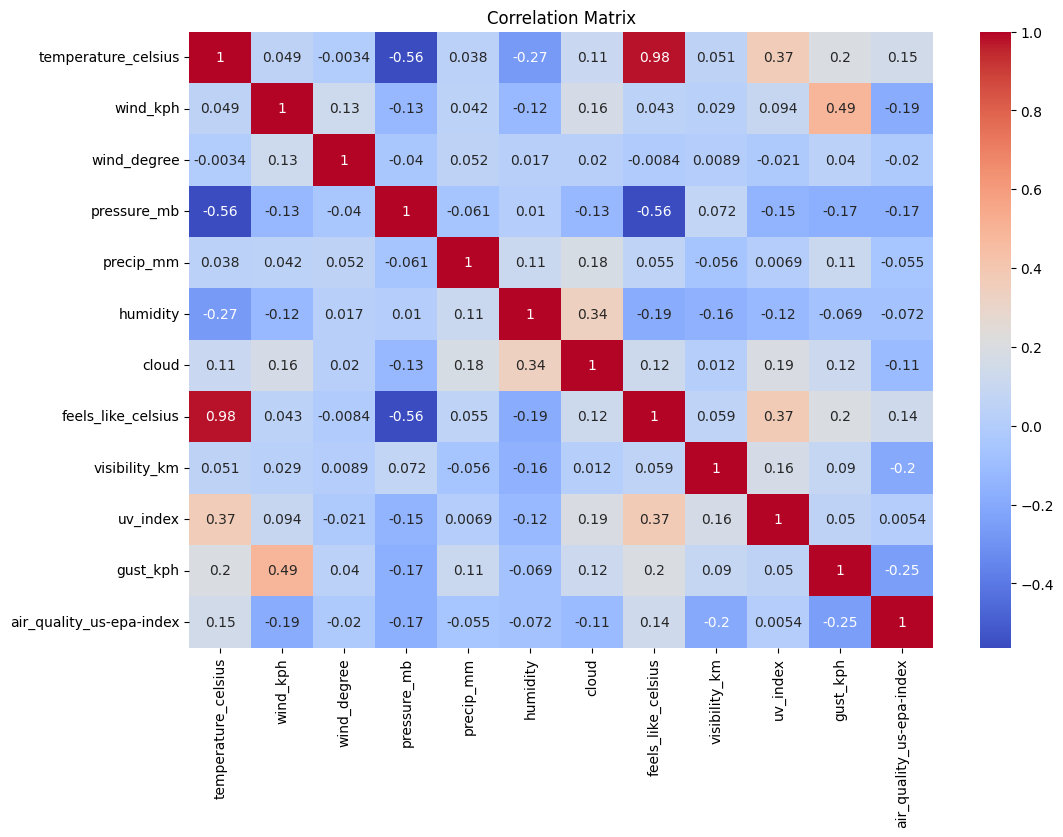

In [ ]:
# Visualize correlations
correlation_matrix = data[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

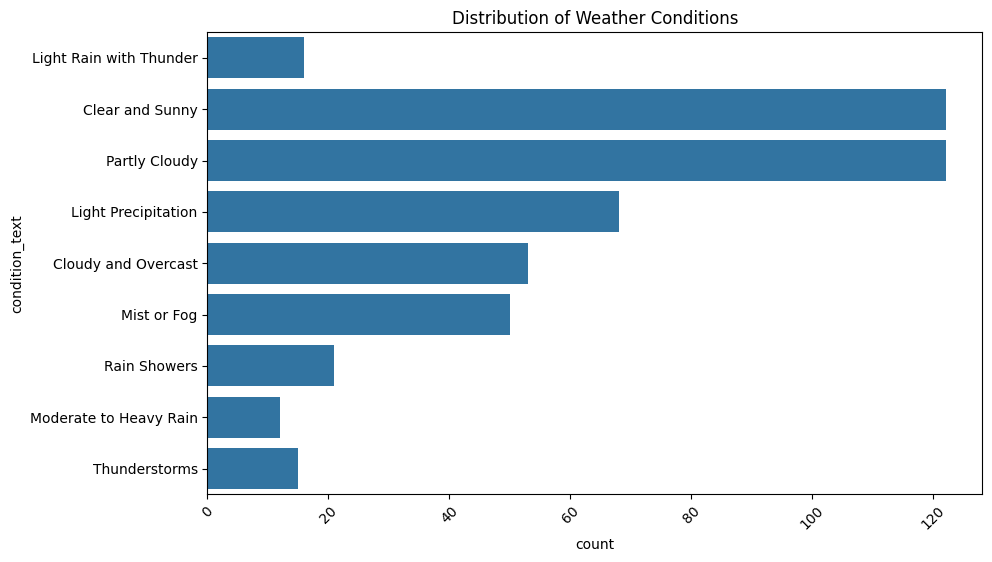

In [ ]:
# Check the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(data['condition_text'])
plt.xticks(rotation=45)
plt.title("Distribution of Weather Conditions")
plt.show()

In [ ]:
data = data.drop(columns=['feels_like_celsius'])

In [ ]:
# Function to convert time string to float representing hour
def time_to_float(time_str):
    if pd.isna(time_str):
        return np.nan

    # Split time string into hour, minute, and period (AM/PM)
    hour_minute, period = time_str.split()
    hour, minute = map(int, hour_minute.split(':'))

    # Adjust hour for PM times
    if period == 'PM' and hour != 12:
        hour += 12

    # Calculate floating point representation of time
    time_float = hour + minute / 60.0
    return time_float

In [ ]:
data['sunrise'] = data['sunrise'].apply(time_to_float)
data['sunset'] = data['sunset'].apply(time_to_float)


In [ ]:
# Encode city_id with LabelEncoder
le = LabelEncoder()
data['city_id'] = le.fit_transform(data['city_id'])

In [ ]:
# Handle missing values for `condition_text`
labeled_data = data.dropna(subset=['condition_text'])
unlabeled_data = data[data['condition_text'].isna()]

In [ ]:
# Prepare features and target variable for modeling
X = labeled_data.drop(columns=['condition_text', 'day_id'])
y = labeled_data['condition_text']

In [ ]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

In [ ]:
X.head()

,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
2,0,20.0,3.6,10,1011.0,4.5,100,75,10.0,1.0,12.6,1,6.083333,19.300000
3,0,17.0,6.1,150,1018.0,0.0,88,0,10.0,1.0,11.2,1,6.100000,19.266667
6,0,21.0,4.0,310,1015.0,0.0,100,50,10.0,1.0,15.1,2,6.133333,19.183333
18,0,19.0,3.6,64,1017.0,0.0,88,0,10.0,1.0,8.3,3,6.333333,18.850000
27,1,19.0,3.6,83,1010.0,0.0,73,25,10.0,1.0,8.3,1,6.283333,19.333333


In [ ]:
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Pipeline for scaling and model training
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Evaluate model
    y_val_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append(accuracy)

In [ ]:
# Average accuracy across all folds
avg_accuracy = np.mean(accuracies)
print(f'Stratified K-Fold Cross-Validation accuracy: {avg_accuracy}')

Stratified K-Fold Cross-Validation accuracy: 0.7182456140350878


In [ ]:
# Semi-Supervised Learning - Self-Training
# Predict on unlabeled data
unlabeled_X = unlabeled_data.drop(columns=['condition_text', 'day_id'])
probas = pipeline.predict_proba(unlabeled_X)
confidence_threshold = 0.9
high_confidence_indices = np.max(probas, axis=1) > confidence_threshold
high_confidence_predictions = pipeline.predict(unlabeled_X[high_confidence_indices])



In [ ]:
# Add high-confidence predictions to labeled data
new_labeled_data = unlabeled_data[high_confidence_indices].copy()
new_labeled_data['condition_text'] = high_confidence_predictions
labeled_data = pd.concat([labeled_data, new_labeled_data])

In [ ]:
# Retrain model with expanded labeled data
X = labeled_data.drop(columns=['condition_text', 'day_id'])
y = labeled_data['condition_text']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale numerical features with MinMaxScaler
scaler = Normalizer()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Parameter grid for RandomForestClassifier
param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable y
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

In [ ]:
# Define the models and their corresponding parameter grids
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'GradientBoosting': (GradientBoostingClassifier(random_state=42),{}),
    'XGBoost': (XGBClassifier(random_state=42), {}),  # Empty dictionary for default parameters
    'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), {})  # Empty dictionary for default parameters
}

# Loop through each model
for model_name, (model, param_grid) in models.items():
    # Define pipeline including preprocessing steps
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=10,
                               verbose=1,
                               n_jobs=-1)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_encoded)

    # Print best parameters and best score
    print(f'Best parameters for {model_name}:')
    print(grid_search.best_params_)
    print(f'Best {model_name} cross-validation score: {grid_search.best_score_:.4f}')

    # Update model with best parameters
    model = grid_search.best_estimator_.named_steps['clf']
    models[model_name] = model  # Update models dictionary with best estimator

# After loop, models dictionary will contain the best models


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters for RandomForest:
{'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best RandomForest cross-validation score: 0.6772
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for GradientBoosting:
{}
Best GradientBoosting cross-validation score: 0.6328
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for XGBoost:
{}
Best XGBoost cross-validation score: 0.6874
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters for LogisticRegression:
{}
Best LogisticRegression cross-validation score: 0.5991


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Define Gaussian Naive Bayes model
nb_model = GaussianNB()

# Train and evaluate using cross-validation
nb_cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')

# Print average accuracy and standard deviation
print(f'Naive Bayes Cross-validation scores: {nb_cv_scores}')
print(f'Average accuracy: {np.mean(nb_cv_scores):.4f} +/- {np.std(nb_cv_scores):.4f}')


Naive Bayes Cross-validation scores: [0.77380952 0.74698795 0.74698795 0.79518072 0.86746988 0.85542169
 0.78313253 0.78313253 0.74698795 0.80722892]
Average accuracy: 0.7906 +/- 0.0406


In [ ]:
# Define ensemble model with tuned models
ensemble = VotingClassifier(estimators=[
    ('rf', models['RandomForest']),
    ('gb', models['GradientBoosting']),
    ('xgb', models['XGBoost']),
    ('lr', models['LogisticRegression']),
    ('nb', nb_model),
], voting='soft')


In [ ]:
# Train ensemble model
ensemble.fit(X_scaled, y)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metri...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('nb', GaussianNB())],
                 voting='soft')

In [ ]:

# Final Prediction on the entire unlabeled set
unlabeled_X_scaled = scaler.transform(unlabeled_X)
final_predictions = ensemble.predict(unlabeled_X_scaled)

In [ ]:
# Prepare submission
submission = unlabeled_data[['day_id']].copy()
submission['condition_text'] = final_predictions

In [ ]:
# Read existing submission.csv
existing_submission = pd.read_csv('submission.csv')

# Merge final predictions with existing_submission based on day_id
final_submission = pd.merge(existing_submission[['day_id']], submission, on='day_id', how='left')

# Save as final_submission.csv
final_submission.to_csv('final_submission.csv', index=False)

print("Final submission file created successfully.")

Final submission file created successfully.


In [ ]:
from sklearn.model_selection import cross_val_score

# Define your pipeline with the final model and scaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ensemble)  # Replace ensemble with your final model
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Print average accuracy and standard deviation
print(f'Cross-validation scores: {cv_scores}')
print(f'Average accuracy: {np.mean(cv_scores):.4f} +/- {np.std(cv_scores):.4f}')


Cross-validation scores: [0.81437126 0.8253012  0.81927711 0.80722892 0.8373494 ]
Average accuracy: 0.8207 +/- 0.0102


In [ ]:
final_submission.shape

(2893, 2)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate on holdout set
y_pred_holdout = pipeline.predict(X_holdout)
accuracy_holdout = accuracy_score(y_holdout, y_pred_holdout)
print(f'Holdout set accuracy: {accuracy_holdout:.4f}')


Holdout set accuracy: 0.8503
